In [1]:
# Notes
# Batch size 32-128
# lr <= 0.0001 for relu
# if we want more data so training > test, can use data augmentation
# experimented with some dropout layers to prevent overfitting, low probability on conv layers, 0.4+ on fc layers
# relu, CrossEntropy and Adam seem to make most sense

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: faranl (faran-team). Use `wandb login --relogin` to force relogin


True

In [3]:
import torch, time, gc
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

plt.rcParams['axes.grid'] = True

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name(0)}')
SAVE_PATH = "./saves/neural_net.pth"

# Training variables
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.0005

# Define the transforms for the dataset
base_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([
    base_transform,
    transforms.CenterCrop(256)
])
augment_transform = transforms.Compose([
    base_transform,
    transforms.RandomApply(
        [transforms.RandomApply([transforms.RandomAffine(degrees=359, translate=(0.2, 0.2), shear=(20, 20, 20, 20)),
                                 transforms.RandomHorizontalFlip(1), transforms.RandomVerticalFlip(1)], p=0.7),
         transforms.ColorJitter(brightness=(0.75, 1.25), contrast=(0.75, 1.25), hue=(-0.15, 0.15),
                                saturation=(0.75, 1.25))
         ]
    )
])

val_accuracies, val_losses, train_accuracies, train_losses = [], [], [], []

# Load the train dataset
train_dataset = datasets.Flowers102(root="./data", split="train", transform=train_transform, download=True)
# train_miniset = Subset(train_dataset, list(random.randint(0, len(train_dataset)) for i in range(32)))
all_train_data = [train_dataset]

# Since augment transform has probability/random changes, we can use it multiple times to generate more training data
for i in range(1):
    all_train_data.append(
        datasets.Flowers102(root="./data", split="train", transform=augment_transform, download=False))
train_dataset_extra = torch.utils.data.ConcatDataset(all_train_data)

train_loader = DataLoader(train_dataset_extra, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Load validation dataset
val_dataset = datasets.Flowers102(root="./data", split="val", transform=base_transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_dataset = datasets.Flowers102(root="./data", split="test", transform=base_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 256 -> 128
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 128 -> 64
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 64 -> 32
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 32 -> 16
        self.conv5 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 16 -> 8
        self.conv6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 8 -> 4
        self.conv7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 4 -> 2
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(2 * 2 * 256, 1024),
                                 nn.ReLU())
        # nn.Dropout(0.65))
        self.fc2 = nn.Sequential(nn.Linear(1024, 1024),
                                 nn.ReLU())
        # nn.Dropout(0.75))
        self.fc3 = nn.Linear(1024, 102)
        # Final output_features size must be 102 as there are 102 labels in the dataset
        # Pool dimensions: out=(in-kernel)/stride + 1

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        # Final output_features size must be 102 as there are 102 labels in the dataset
        # Pool dimensions: out=(in-kernel)/stride + 1

Using NVIDIA GeForce RTX 3070 Laptop GPU


In [4]:
def train_one_epoch(net: nn.Module = None, training_loss: [] = None, training_acc: [] = None, optimizer=None):
    if optimizer is None:
        optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE)

    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.eye(102)[labels]  # one hot encode
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)  # train
        labels = torch.argmax(labels, dim=1)  # one hot decode

        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels).sum().item()

    running_loss /= len(train_dataset_extra)
    train_accuracy = 100 * correct / total
    # save data
    training_loss.append(running_loss)
    training_acc.append(train_accuracy)
    print(f'Training Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    return training_loss, training_acc


In [5]:
def validate_one_epoch(net: nn.Module = None, valid_loss: [] = None, valid_acc: [] = None):
    net.eval()
    with torch.no_grad():
        running_vloss = 0.0
        vcorrect = 0
        vtotal = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            vloss = criterion(outputs, labels)
            running_vloss += vloss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            vtotal += labels.size(0)
            vcorrect += (predicted == labels).sum().item()

        vaccuracy = 100 * vcorrect / vtotal

        # save validation data
        running_vloss /= len(val_dataset)
        valid_loss.append(running_vloss)
        valid_acc.append(vaccuracy)
        print(f'Validation Loss: {running_vloss:.4f}, Accuracy: {vaccuracy:.2f}%')
        return valid_loss, valid_acc

In [6]:
def train_net(net: nn.Module = None, epochs: int = 1, validation_loss=None, validation_accuracy=None,
              training_loss=None, training_accuracy=None, epochs_already_trained: int = 0):
    optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE)

    if training_accuracy is None:
        training_accuracy = []
    if training_loss is None:
        training_loss = []
    if validation_accuracy is None:
        validation_accuracy = []
    if validation_loss is None:
        validation_loss = []

    epochs += epochs_already_trained
    for epoch in range(epochs_already_trained, epochs):
        print(f'Epoch: [{epoch + 1}/{epochs}]')

        training_loss, training_accuracy = train_one_epoch(net, training_loss=training_loss,
                                                           training_acc=training_accuracy, optimizer=optimizer)
        validation_loss, validation_accuracy = validate_one_epoch(net, valid_loss=validation_loss,
                                                                  valid_acc=validation_accuracy)

        torch.save(net.state_dict(), SAVE_PATH)
        with open("./saves/save_data.txt", "w") as savefile:
            savefile.writelines(str(validation_loss))
            savefile.writelines(str(validation_accuracy))
            savefile.writelines(str(training_loss))
            savefile.writelines(str(training_accuracy))
            savefile.write(str(epoch + 1))

        wandb.log({"train_acc": training_accuracy[-1], "train_loss": training_loss[-1], "val_acc": validation_accuracy[-1], "val_loss": validation_loss[-1]})
        print("NN saved.")
    wandb.finish()


In [7]:
def train_net_from_save(epochs: int = 1, save_folder_path: str = "./saves"):
    print("Resuming training from save.")
    net = CNN().to(device)
    net.load_state_dict(torch.load(save_folder_path + "/neural_net.pth"))
    with open(save_folder_path + "/save_data.txt", "r") as savefile:
        savelist = savefile.readline().split("]")
        v_losses, v_accs, t_losses, t_accs = [], [], [], []
        for vloss in savelist[0][1::].split(","):
            v_losses.append(float(vloss.strip()))
        for vacc in savelist[1][1::].split(","):
            v_accs.append(float(vacc.strip()))
        for tloss in savelist[2][1::].split(","):
            t_losses.append(float(tloss.strip()))
        for tacc in savelist[3][1::].split(","):
            t_accs.append(float(tacc.strip()))
        epochs_done = int(savelist[4])
    print("Net loaded. " + str(epochs_done) + " epochs previously trained.")
    train_net(net=net, epochs=epochs, validation_loss=v_losses, validation_accuracy=v_accs, training_accuracy=t_accs,
              training_loss=t_losses, epochs_already_trained=epochs_done)

In [8]:
def test_net(net: nn.Module = None):
    if net is None:
        try:
            net = CNN().to(device)
            net.load_state_dict(torch.load("./saves/neural_net.pth"))
        except:
            return
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            # pred_labels = torch.argmax(outputs, axis=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy: {(100 * correct / total):.2f}%")

In [9]:
def test_net_from_save(save_folder_path: str = "./saves"):
    net = CNN().to(device)
    net.load_state_dict(torch.load(save_folder_path + "/neural_net.pth"))
    test_net(net)

In [10]:
wandb.init(
    project="256L",
    config={
        "learning_rate": LEARNING_RATE,
        "architecture": "CNN-256L",
        "dataset": "Flowers102",
        "epochs": EPOCHS,
        "weight_decay": WEIGHT_DECAY
    }
)

In [11]:
# Clear cuda cache
gc.collect()
torch.cuda.empty_cache()

# Create an instance of the CNN and move it to the device
cnn = CNN().to(device)
print(cnn)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm

In [12]:
print("Starting training.")
# Start timer
start_time = time.time()

train_net(cnn, EPOCHS)

# Stop timer
end_time = time.time()
print("Training Complete in: " + time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)))

Starting training.
Epoch: [1/20]
Training Loss: 4.6062, Accuracy: 2.11%
Validation Loss: 4.5738, Accuracy: 3.92%
NN saved.
Epoch: [2/20]
Training Loss: 4.5267, Accuracy: 8.53%
Validation Loss: 4.5035, Accuracy: 6.08%
NN saved.
Epoch: [3/20]
Training Loss: 4.4398, Accuracy: 14.61%
Validation Loss: 4.4145, Accuracy: 8.63%
NN saved.
Epoch: [4/20]
Training Loss: 4.3209, Accuracy: 20.54%
Validation Loss: 4.2954, Accuracy: 9.51%
NN saved.
Epoch: [5/20]
Training Loss: 4.1761, Accuracy: 21.81%
Validation Loss: 4.1496, Accuracy: 12.06%
NN saved.
Epoch: [6/20]
Training Loss: 4.0112, Accuracy: 29.75%
Validation Loss: 4.0170, Accuracy: 14.90%
NN saved.
Epoch: [7/20]
Training Loss: 3.8391, Accuracy: 35.29%
Validation Loss: 3.8916, Accuracy: 16.86%
NN saved.
Epoch: [8/20]
Training Loss: 3.6620, Accuracy: 37.70%
Validation Loss: 3.7549, Accuracy: 20.20%
NN saved.
Epoch: [9/20]
Training Loss: 3.4832, Accuracy: 45.44%
Validation Loss: 3.6316, Accuracy: 22.06%
NN saved.
Epoch: [10/20]
Training Loss: 3.3

Training Complete in: 00h 08m 19s


In [13]:
# train_net_from_save(1)

In [14]:
# Test the CNN
test_net(net=cnn)

Test Accuracy: 31.84%


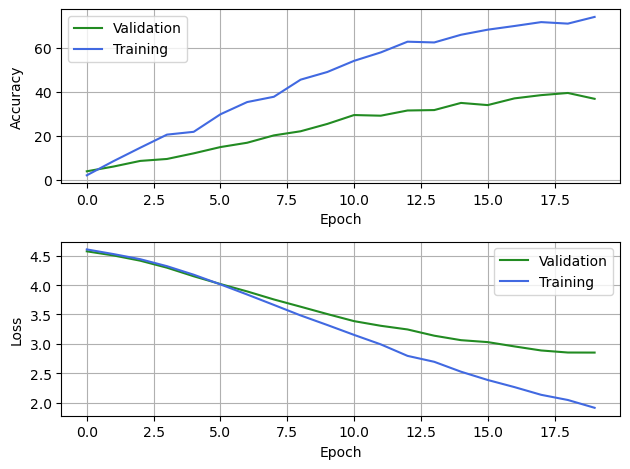

In [15]:
# Plot
fig = plt.figure(tight_layout=True)
gs = grid.GridSpec(nrows=2, ncols=1)


# for i in range(len(train_losses)):
#     train_losses[i]*=len(all_train_data)
def plot_epochs(ax, data: [[int]], ylabel: str, datalabels: [str], cs: [str]):
    if len(datalabels) == len(data):
        for line in range(len(data)):
            ax.plot(data[line], label=datalabels[line], c=cs[line])
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
        fig.align_labels()
        plt.legend()


line_labels = ["Validation", "Training"]
colours = ["forestgreen", "royalblue"]
with open("./saves/save_data.txt", "r") as savefile:
    savelist = savefile.readline().split("]")
    v_losses, v_accs, t_losses, t_accs = [], [], [], []
    for vloss in savelist[0][1::].split(","):
        v_losses.append(float(vloss.strip()))
    for vacc in savelist[1][1::].split(","):
        v_accs.append(float(vacc.strip()))
    for tloss in savelist[2][1::].split(","):
        t_losses.append(float(tloss.strip()))
    for tacc in savelist[3][1::].split(","):
        t_accs.append(float(tacc.strip()))
    epochs_done = int(savelist[4])
    plot_epochs(fig.add_subplot(gs[0, 0]), [v_accs, t_accs], "Accuracy", line_labels, colours)
    plot_epochs(fig.add_subplot(gs[1, 0]), [v_losses, t_losses], "Loss", line_labels, colours)
    plt.show()
    fig.savefig("figs/training_graph.png")